In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR


%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module wa

# PIPELINE

## IMPORT AND CLEANING

### IMPORT

In [2]:
dt = pd.read_csv('winequality.csv', sep=";")

### CLEANING

In [3]:
dt.loc[dt.alcohol.str.match('[0-9]+\.+[0-9]+\.+'),'alcohol'] = dt.loc[dt.alcohol.str.match('[0-9]+\.+[0-9]+\.+'),:]['alcohol'].apply(lambda x: x.split('.')[0]).map(lambda x: int(x)/10)
dt.alcohol = dt['alcohol'].map(float)

In [4]:
dt=pd.get_dummies(dt,drop_first=True)

## MODELS

In [5]:
train, test = train_test_split(dt,test_size = 0.2)

### LINEAR

In [26]:
scaler = RobustScaler(quantile_range=(0.01,0.99))
poly = PolynomialFeatures()
lasso = Lasso()

In [27]:
pipe= Pipeline([('scaler',scaler),
               ('poly', poly),
               ('lasso',lasso)])

In [64]:
pipe_params = {'lasso__alpha':(16,20,24,28,32), 'poly__degree': (3,4,5)}
grid = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_absolute_error',verbose = 1,cv = 5)
grid.fit(X = dt.drop('quality', axis = 1).values, y = dt.quality)

In [67]:
print(grid.best_score_)
print(grid.best_params_)

-0.7007524692508277

In [87]:
y_pred = grid.predict(dt.drop('quality', axis = 1).values)
y_res = np.abs(dt.quality-y_pred)
print(r2_score(y_pred,dt.quality))
print(mean_absolute_error(y_pred,dt.quality))

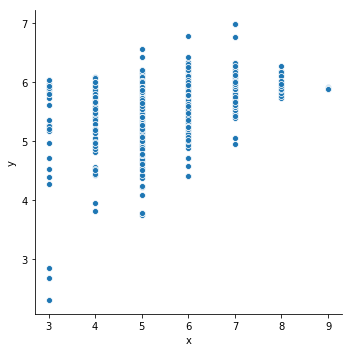

In [89]:
dt_plot = pd.DataFrame({'x':dt.quality, 'y': y_pred})
sns.relplot(data = dt_plot, x = 'x', y = 'y')

### SVM

In [11]:
svr = SVR(C = 1, epsilon= 1, kernel = 'poly' )
scaler = RobustScaler(quantile_range=(0.01,0.99))
pipe= Pipeline([('scaler',scaler),
               #('poly', poly),
               ('svr',svr)])

In [ ]:
pipe.fit(train.drop('quality',axis = 1).values, train.quality)

In [10]:
?pipe.fit

In [9]:
y_pred = pipe.predict(test.drop('quality',axis = 1))

-7.213757389722547
0.6144080720521079


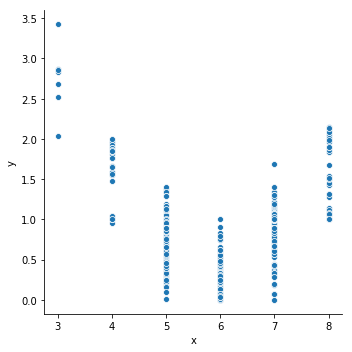

In [13]:
print(r2_score(y_pred, test.quality))
print(mean_absolute_error(y_pred, test.quality))
y_res = np.abs(test.quality-y_pred)
dt_plot = pd.DataFrame({'x':test.quality, 'y': np.abs(y_pred-test.quality)})
sns.relplot(data = dt_plot, x = 'x', y = 'y')

In [ ]:
pipe_params = {'svr__kernel' : ('poly', 'rbf')}
grid = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_absolute_error',verbose = 2,cv = 2)
grid.fit(X = dt.drop('quality', axis = 1).values, y = dt.quality)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] svr__kernel=poly ................................................


In [105]:
print(grid.best_score_)
print(grid.best_params_)

-0.6526182868308054
{'svr__C': 1, 'svr__epsilon': 1}


In [106]:
y_pred = grid.predict(dt.drop('quality', axis = 1).values)
y_res = np.abs(dt.quality-y_pred)
print(r2_score(y_pred,dt.quality))
print(mean_absolute_error(y_pred,dt.quality))

-2.677027582285753
0.5695288979010193


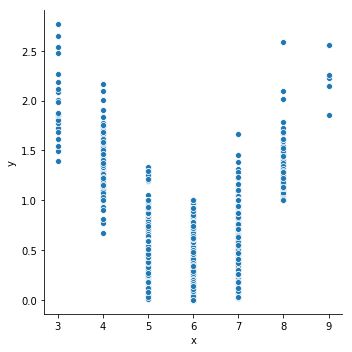

In [109]:
dt_plot = pd.DataFrame({'x':dt.quality, 'y': np.abs(y_pred-dt.quality)})
sns.relplot(data = dt_plot, x = 'x', y = 'y')